<a href="https://colab.research.google.com/github/MarioROT/IHLT-MAI/blob/main/Session8_MarioRosas_AlamLopez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab session 8 (Syntactic Parser) - IHLT

**Students:**
- Mario Rosas
- Alam Lopez

**Lab Professor:** Salvador Medina Herrera

## Paraphrases Template

In [12]:
%%shell
git clone https://github.com/mariorot/IHLT-MAI.git
cd 'IHLT-MAI'
mv 'complementary_material' /content/
mv scripts /content/
pip install svgling
pip install python-crfsuite

fatal: destination path 'IHLT-MAI' already exists and is not an empty directory.
mv: cannot stat 'complementary_material': No such file or directory
mv: cannot stat 'scripts': No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 13.6 MB/s eta 0:00:00


In [13]:
import nltk
from nltk import CFG, ChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser
import svgling
from scripts.text_preprocessing import TextPreprocessing
import string
import numpy as np

## TODO

- Consider the following sentence: **Lazy cats play with mice.**

- Expand the grammar of the example related to non-probabilistic chart parsers in order to subsume this new sentence.

- Perform the constituency parsing using a BottomUpChartParser, a BottomUpLeftCornerChartParser and a LeftCornerChartParser.

- For each one of them, provide the resulting tree, the number of edges and the list of explored edges.

- Which parser is the most efficient for parsing the sentence?

- Which edges are filtered out by each parser and why?

#### Failed attempt to generate grammar automatically

In [27]:
def sentence_to_cfg(sentence):
    words = TextPreprocessing().clean_sentence(sentence, signs=string.punctuation)
    pos_tags = nltk.pos_tag(words)

    productions = []

    for i in range(len(pos_tags)):
        productions.append(f"Word_{i} -> '{words[i]}'")
        productions.append(f"POS_{i} -> '{pos_tags[i][1]}'")

    for i in range(len(pos_tags) - 1):
        productions.append(f"Phrase_{i} -> Word_{i} | POS_{i}")
        productions.append(f"Sentence -> Phrase_{i} Phrase_{i+1}")

    cfg_string = "\n".join(productions)

    return CFG.fromstring(cfg_string)

# Example sentence
sentence = "The cat chased the mouse"

# Convert sentence to CFG
cfg = sentence_to_cfg(sentence)

# Print the CFG
print(cfg)

Grammar with 22 productions (start state = Word_0)
    Word_0 -> 'the'
    POS_0 -> 'DT'
    Word_1 -> 'cat'
    POS_1 -> 'NN'
    Word_2 -> 'chased'
    POS_2 -> 'VBD'
    Word_3 -> 'the'
    POS_3 -> 'DT'
    Word_4 -> 'mouse'
    POS_4 -> 'NN'
    Phrase_0 -> Word_0
    Phrase_0 -> POS_0
    Sentence -> Phrase_0 Phrase_1
    Phrase_1 -> Word_1
    Phrase_1 -> POS_1
    Sentence -> Phrase_1 Phrase_2
    Phrase_2 -> Word_2
    Phrase_2 -> POS_2
    Sentence -> Phrase_2 Phrase_3
    Phrase_3 -> Word_3
    Phrase_3 -> POS_3
    Sentence -> Phrase_3 Phrase_4


#### Introducing grammar manually

In [28]:
class sentence_to_cfg_parsing():
    def __init__(self, grammar):
      self.grammar = grammar
      self.pMethods = {'chart':ChartParser,
                       'bottomUp':BottomUpChartParser,
                       'bottomUpLeft':BottomUpLeftCornerChartParser,
                       'left': LeftCornerChartParser}

    def parse(self, sentence, method, rTree=0, verbose = False):
      print(f"---------- Using {method}")
      words = TextPreprocessing().clean_sentence(sentence, signs=string.punctuation)
      pos_tags = nltk.pos_tag(words)

      if verbose:
        print("\nPart of Speech of the sentence: ", pos_tags)

      parser = self.pMethods[method](self.grammar, trace=1)
      print('\n-- Char Parse')
      cparse = parser.chart_parse(words)
      print('\n-- Parse')
      parse = parser.parse(words)
      print(f'\n--Number of edges: {cparse.num_edges()}')
      print(f'\n-- Explored edges:\n {np.array(cparse.edges())}')
      trees = list(parse)
      print(f'\n--Number of trees:\n {len(trees)}')
      print("\n--Trees:")
      for i, tree in enumerate(trees):
        print(f'---Tree {i}: ', tree)

      if len(trees) != 0:
        print("\n")
        return trees[rTree]
      else:
        return "No Trees Found!"

In [32]:
grammar = CFG.fromstring('''
  S   -> NP VB IN NP
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or"
  VB -> "play"
  IN  -> "with"
  ''')

grammar2 = CFG.fromstring('''
  S   -> NP VB IN NP
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or"
  VB -> "play"
  IN  -> "with"
  ''')

s1="Lazy cats play with mice"
s2="Lazy cats and mice"
s3="small cats and mice"

##### Testing with grammar 1

In [30]:
CFGParse = sentence_to_cfg_parsing(grammar)

In [33]:
CFGParse.parse(s1, 'chart', 1, True)

---------- Using chart

Part of Speech of the sentence:  [('lazy', 'NN'), ('cats', 'NNS'), ('play', 'VBP'), ('with', 'IN'), ('mice', 'NNS')]

-- Char Parse
|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       [------->       .       .       .| [1:2] NNS -> NNS * CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] NP -> NP * CC NP
|.       [------->       .       .       .| [1:2] NP ->

'No Trees Found!'

---------- Using left

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC -> 'and' *

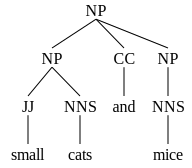

In [19]:
CFGParse.parse(s3, 'left', 1, True)

---------- Using bottomUp

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|>         .         .         .         .| [0:0] JJ -> * 'small'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|>         .         .         .         .| [0:0] NP -> * JJ NNS
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         >         .         .         .| [1:1] NNS -> * 'cats'
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         >         .         .         .| [1:1] NP -> * NNS
|.         >         .         .         .| [1:1] NNS -> * NNS CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NN

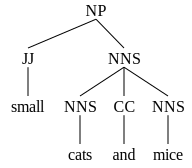

In [ ]:
CFGParse.parse(s3, 'bottomUp', 1, True)

---------- Using bottomUpLeft

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC ->

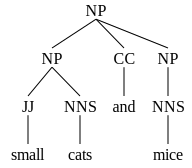

In [ ]:
CFGParse.parse(s3, 'bottomUpLeft', 1, True)

##### Testing with grammar 2

In [ ]:
CFGParse = sentence_to_cfg_parsing(grammar2)

In [ ]:
CFGParse.parse(s3, 'chart', 0, True)

---------- Using chart

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] S  -> NP * VB IN NP
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] S  -> NP 

'No Trees Found!'

In [ ]:
CFGParse.parse(s3, 'left', 0, True)

---------- Using left

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC -> 'and' *

'No Trees Found!'

In [ ]:
CFGParse.parse(s3, 'bottomUp', 0, True)

---------- Using bottomUp

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|>         .         .         .         .| [0:0] JJ -> * 'small'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|>         .         .         .         .| [0:0] NP -> * JJ NNS
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         >         .         .         .| [1:1] NNS -> * 'cats'
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         >         .         .         .| [1:1] NP -> * NNS
|.         >         .         .         .| [1:1] NNS -> * NNS CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NN

'No Trees Found!'

In [ ]:
CFGParse.parse(s3, 'bottomUpLeft', 0, True)

---------- Using bottomUpLeft

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] S  -> NP * VB IN NP
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] S 

'No Trees Found!'

In [35]:


nltk.parse.chart.demo(2, print_times=False, trace=1, sent='Lazy cats play with mice', numparses=1)

* Sentence:
Lazy cats play with mice
['Lazy', 'cats', 'play', 'with', 'mice']

* Strategy: Bottom-up



ValueError: ignored

**Conclusions:**

- Since parsing is a search problem, we can then say that the eficiency of the parsers can be measured as the number of edges explored before to find a solution. The lower the edges explored, the more efficient the parser is.

- Using this logic, then we can say that the most efficient parser for the test sentences is the **left corner chart parser.**

This makes sense since it is a top-down strategy with left corner information. While the other two are bottom-up strategies, and Bottom-up tend to expand more nodes that the top-down strategies.

The reason of the previous statement is that:

- Bottom-Up starts with individual words and works upwards to build larger parts until the complete sentence is formed.

- Top-down starts with the entire sentence and recursively breaks it down into smaller parts until individual words are reached. Which leads to less expansion.

- Also, when adding left corner information to the strategy, the parser avoid unnecesary expansions which also improves efficiency.


We can also see, that the CFG rules chosen (or grammatical rules) can impact the strategies, even leading to searches where no tree is found.  

For example, with the test sentence and grammars we implemented, we can see some differences in the grammars:

- Grammar 1:
Allows us for more complex noun phrases with adjectives and conjunctions whic leads to more flexibility in constructing varied sentence structures. However, it does not explicitly define sentence structures, making it less restrictive.

- Grammar 2:
It introduces a top-level sentence rule, providing a more explicit sentence structure. But still allows for a broad range of sentence structures without specific verb phrase details.

- Grammar 3:
Explicitly defines sentence structures with rules for noun phrases, verb phrases, and prepositional phrases. However, may be more restrictive in terms of sentence structures compared to the previous grammars.


If we want flexibility and a wide range of sentence structures, we need to define a more general Grammar structure which can capture all the possible combinations of the sentences.

Ultimately, the better grammar depends on the specific requirements for sentence generation and the level of structural detail we want to capture in the parsing trees.